# 2. Preparacion de datos
This notebook has the code needed to prepare data for the regression model, analyzing data cleaniness dimensions.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scripts import univariate_utils, multivariate_utils

## Constants

In [2]:
LOADING_FILE_PATH = "data/gapminder_with_extras.parquet"

In [3]:
SAVING_FILE_PATH = "data/gapminder_clean.parquet"

In [4]:
PERCENTILES = [0.05,0.25,0.50,0.75,0.95]

##  Utils

In [5]:
def fill_na_group(df, na_col, group_col):
    """Fills na with averaging of group"""
    group_values = df.groupby(group_col)[na_col].transform("mean")
    is_null_val = df[na_col].isnull()
    df[na_col] = np.where(
        is_null_val,
        group_values,
        df[na_col]
    )

In [6]:
def clip_data_by_iqr(df, col, strategy, iqr_multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    bottom_limit = Q1 - iqr_multiplier * IQR
    top_limit = Q3 + iqr_multiplier * IQR
    
    is_low = df[col] <= bottom_limit
    is_high = df[col] >= top_limit
    
    if strategy == "bottom":
        df.loc[is_low, col] = bottom_limit
    if strategy == "top":
        df.loc[is_high, col] = top_limit
    else:
        df.loc[is_low, col] = bottom_limit
        df.loc[is_high, col] = top_limit

## Execution

### Load data

In [7]:
df_pib = pd.read_parquet(LOADING_FILE_PATH)

In [8]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1

### country
- **Table level consistency:** Duplicated countries. Solution: Drop duplicates.

In [9]:
df_pib["country"].nunique()

166

In [10]:
len(df_pib)

178

In [11]:
df_country_count = df_pib["country"].value_counts()
df_country_count[df_country_count > 1]

country
Ireland           2
Luxembourg        2
Malaysia          2
Belarus           2
Tajikistan        2
Iran              2
Macedonia, FYR    2
Sudan             2
Lithuania         2
Vietnam           2
Switzerland       2
Oman              2
Name: count, dtype: int64

In [12]:
df_pib.drop_duplicates(
    subset="country",
    inplace=True
)

In [13]:
df_pib["country"].nunique() == len(df_pib)

True

In [14]:
sorted(df_pib["country"].tolist())

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Central African Rep.',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Rep.',
 'Denmark',
 'Djibouti',
 'Dominican Rep.',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Ita

### incomeperperson
- Attribute level completeness: Income per person has 3 empty values. Solution: Fill them with region average.
- Attribute level accordance: Some countries have GDP over 30000 and that may difficult to predict for the regressor.

In [15]:
df_pib["incomeperperson"].isnull().sum()

3

In [16]:
df_pib[df_pib["incomeperperson"].isnull()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate,independent,region,subregion,landlocked,area,is_developed
68,Kuwait,NaN,0.10,1.609548,31.8,1.712755e+09,42.0,NaN,38.260234,74.576,6.467568,-7.0,8362.567977,1.498057,65.699997,98.36,True,Asia,Western Asia,False,17818.0,True
100,Afghanistan,NaN,0.03,0.569653,26.8,7.594400e+07,25.6,NaN,3.654122,48.673,NaN,0.0,NaN,6.684385,55.700001,24.04,True,Asia,Southern Asia,True,652230.0,False
134,Myanmar,NaN,0.58,1.912965,20.2,3.229600e+08,66.5,0.6,NaN,65.193,NaN,-6.0,38.005637,10.114997,74.699997,32.58,True,Asia,South-Eastern Asia,False,676578.0,False


In [17]:
fill_na_group(df_pib, "incomeperperson", "region")

In [18]:
df_pib["incomeperperson"].isnull().sum()

0

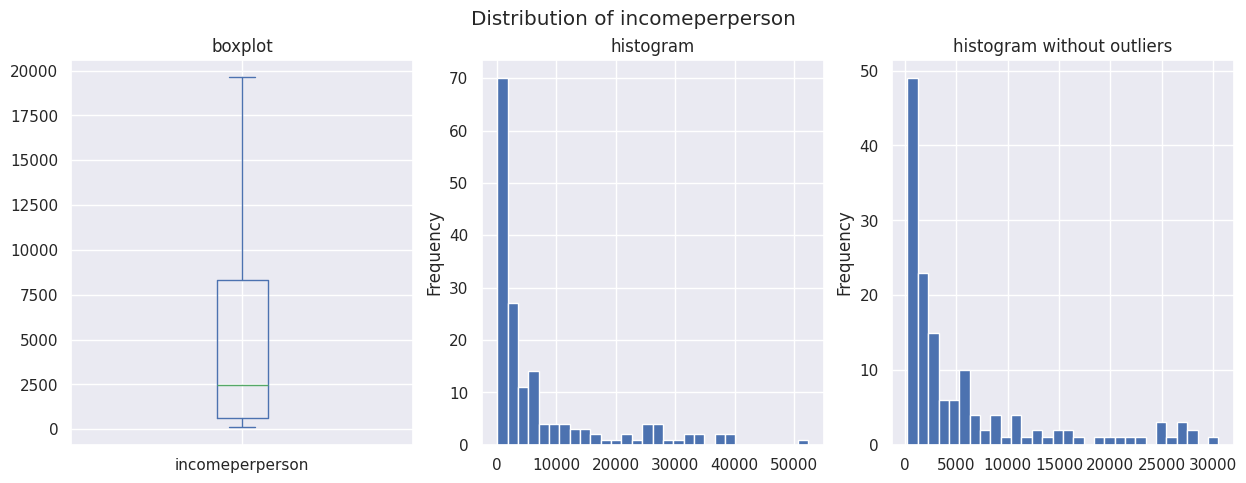

In [19]:
univariate_utils.plot_column_distribution(
  df_pib,
  "incomeperperson",
  (15,5),
  30
)

In [20]:
clip_data_by_iqr(df_pib, "incomeperperson", "top", 1.5)

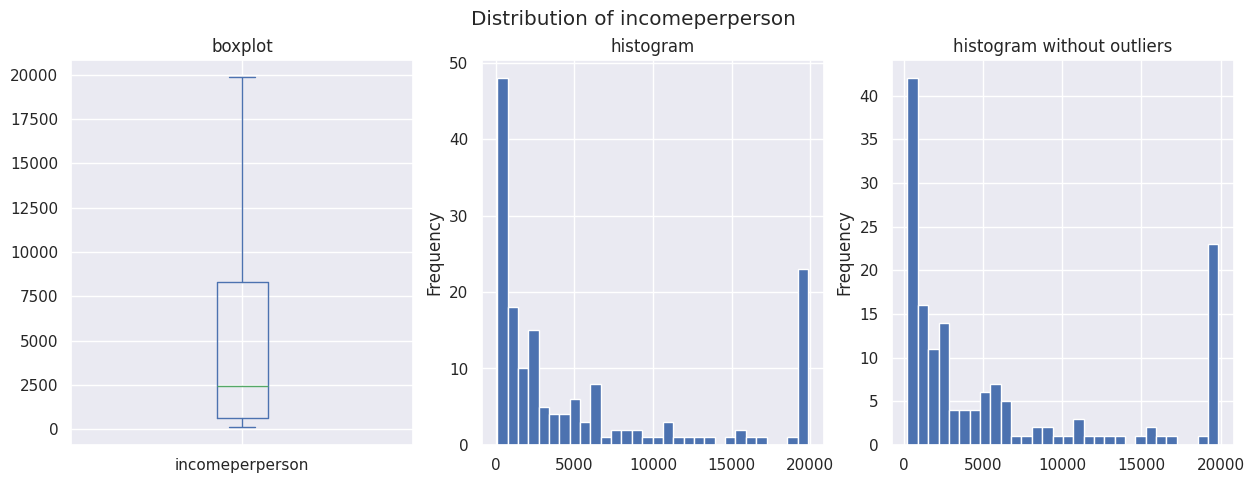

In [21]:
univariate_utils.plot_column_distribution(
  df_pib,
  "incomeperperson",
  (15,5),
  30
)

### alcconsumption
- Attribute level accordance: Some countries have alcconsumption over 15 and that may difficult to predict for the regressor.

In [22]:
df_pib["alcconsumption"].isnull().sum()

0

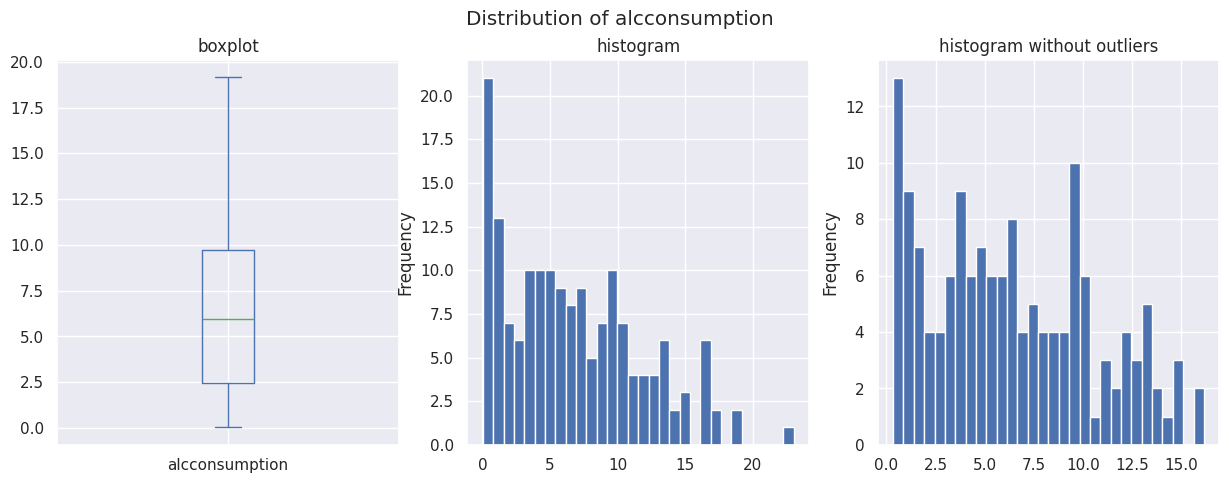

In [23]:
univariate_utils.plot_column_distribution(
  df_pib,
  "alcconsumption",
  (15,5),
  30
)

In [24]:
clip_data_by_iqr(df_pib, "alcconsumption", "top", 1.5)

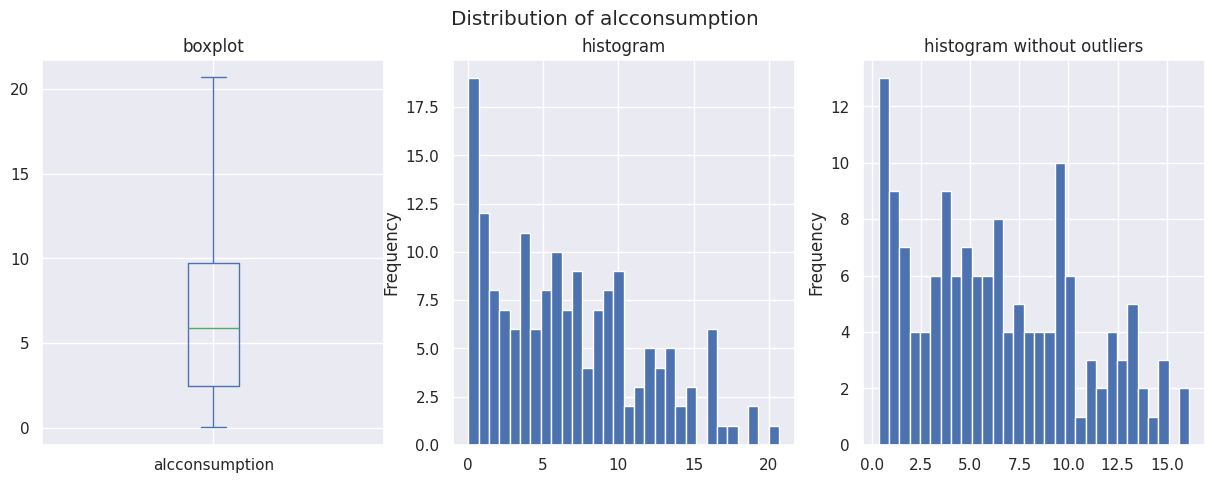

In [25]:
univariate_utils.plot_column_distribution(
  df_pib,
  "alcconsumption",
  (15,5),
  30
)

### armedforcesrate
- Attribute level completeness: armedforcesrate has 4 empty values. Solution: Fill them with region average.
- Attribute level accordance: Some countries have armedforcesrate over 4 and that may difficult to predict for the regressor.

In [26]:
df_pib["armedforcesrate"].isnull().sum()

4

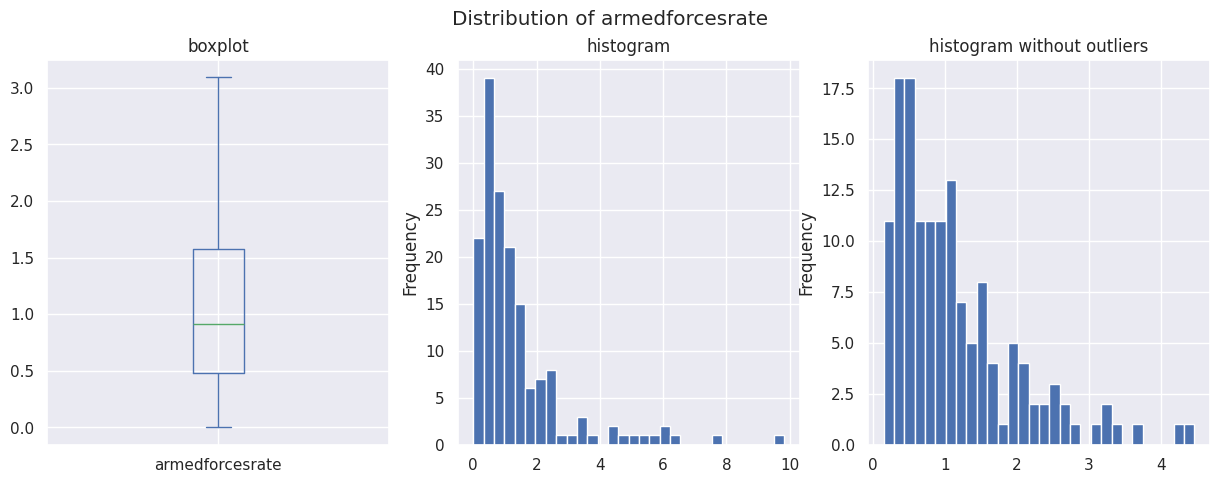

In [27]:
univariate_utils.plot_column_distribution(
  df_pib,
  "armedforcesrate",
  (15,5),
  30
)

In [28]:
fill_na_group(df_pib, "armedforcesrate", "region")

In [29]:
df_pib["armedforcesrate"].isnull().sum()

0

In [30]:
clip_data_by_iqr(df_pib, "armedforcesrate", "top", 1.5)

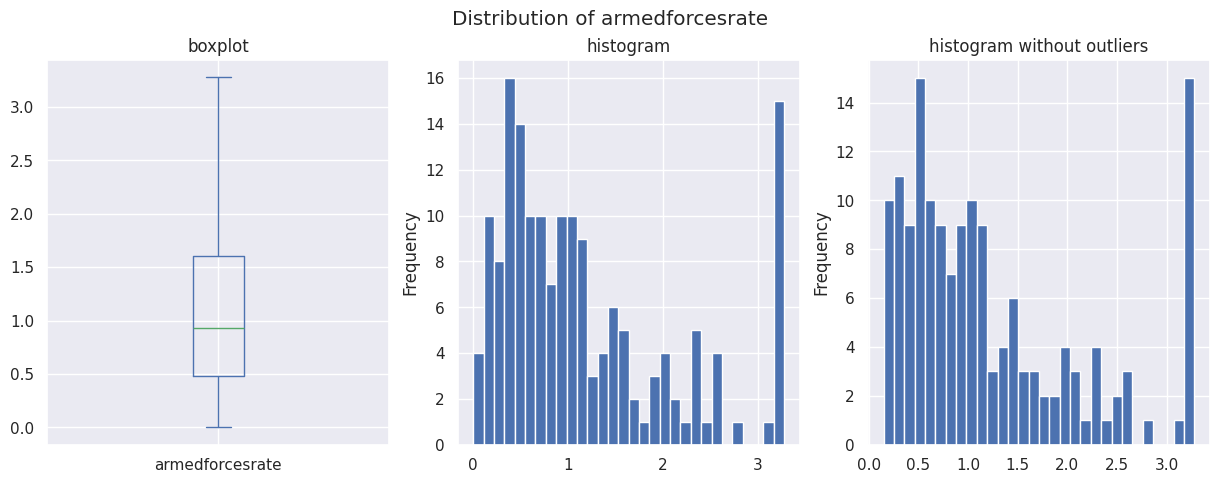

In [31]:
univariate_utils.plot_column_distribution(
  df_pib,
  "armedforcesrate",
  (15,5),
  30
)

### breastcancerper100th
- Attribute level completeness: breastcancerper100th has 1 empty value. Solution: Fill them with region average.

In [32]:
df_pib["breastcancerper100th"].isnull().sum()

1

In [33]:
fill_na_group(df_pib, "breastcancerper100th", "region")

In [34]:
df_pib["breastcancerper100th"].isnull().sum()

0

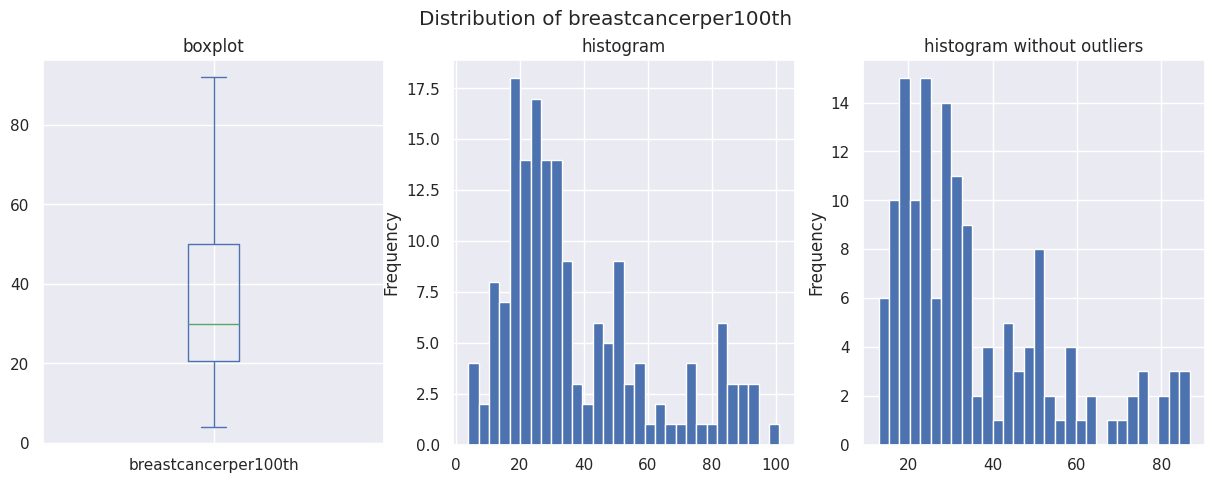

In [35]:
univariate_utils.plot_column_distribution(
  df_pib,
  "breastcancerper100th",
  (15,5),
  30
)

### co2emissions
- Attribute level completeness: co2emissions has 2 empty values. Solution: Fill them with region average.
- Attribute level accordance: Some countries have very extreme c2 emissions.

In [36]:
df_pib["co2emissions"].isnull().sum()

2

In [37]:
fill_na_group(df_pib, "co2emissions", "region")

In [38]:
df_pib["co2emissions"].isnull().sum()

0

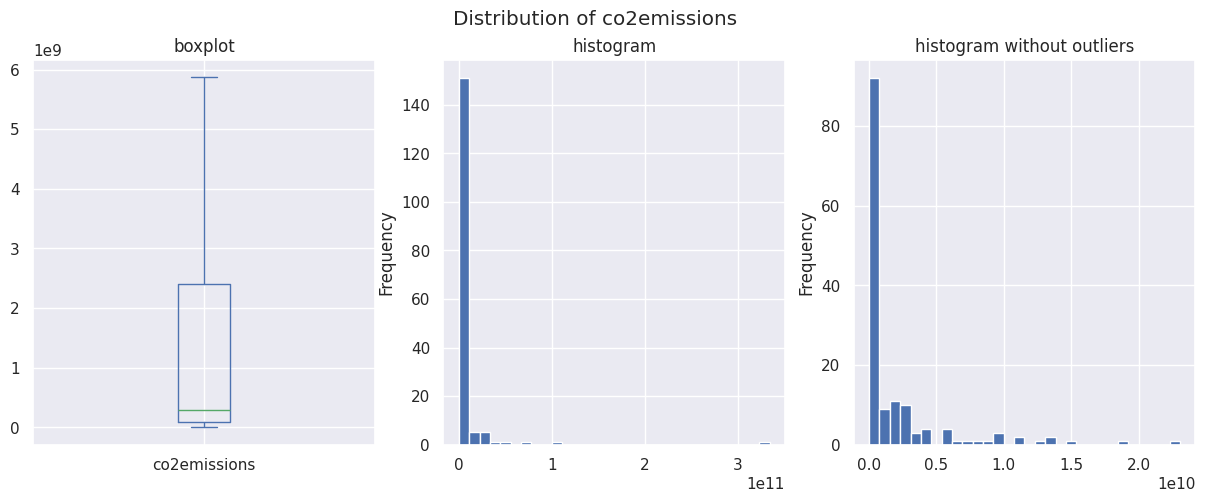

In [39]:
univariate_utils.plot_column_distribution(
  df_pib,
  "co2emissions",
  (15,5),
  30
)

In [40]:
clip_data_by_iqr(df_pib, "co2emissions", "top", 1.5)

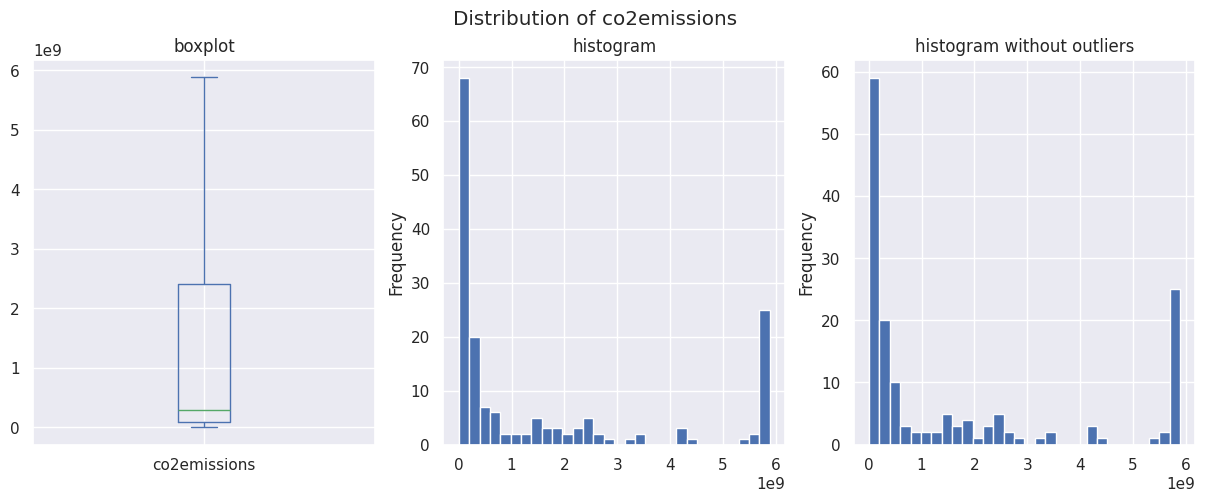

In [41]:
univariate_utils.plot_column_distribution(
  df_pib,
  "co2emissions",
  (15,5),
  30
)

### femaleemployrate
- Attribute level completeness: femaleemployrate has 1 empty value. Solution: Fill them with region average.

In [42]:
df_pib["femaleemployrate"].isnull().sum()

1

In [43]:
fill_na_group(df_pib, "femaleemployrate", "region")

In [44]:
df_pib["femaleemployrate"].isnull().sum()

0

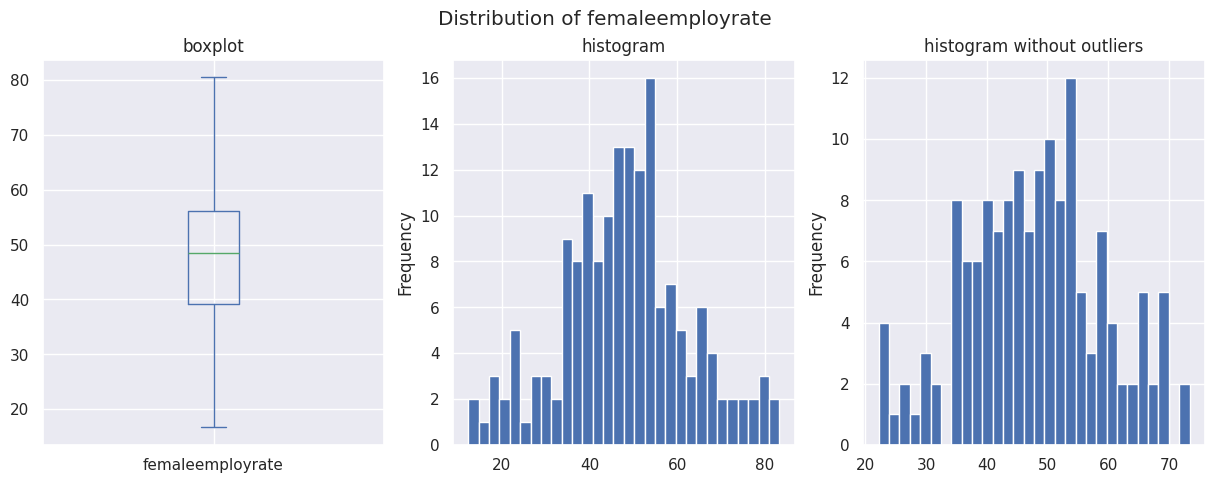

In [45]:
univariate_utils.plot_column_distribution(
  df_pib,
  "femaleemployrate",
  (15,5),
  30
)

### hivrate
- Column level completeness: hivrate has 13% of empty values. It is too high to treat with, so the column is dropped.

In [46]:
df_pib["hivrate"].isnull().sum()

22

In [47]:
df_pib["hivrate"].isnull().sum()/len(df_pib["hivrate"])

0.13253012048192772

In [48]:
df_pib.drop(columns="hivrate", inplace=True)

### internetuserate
- Attribute level completeness: internetuserate has 3 empty values. Solution: Fill them with region average.

In [49]:
df_pib["internetuserate"].isnull().sum()

3

In [50]:
fill_na_group(df_pib, "internetuserate", "region")

In [51]:
df_pib["internetuserate"].isnull().sum()

0

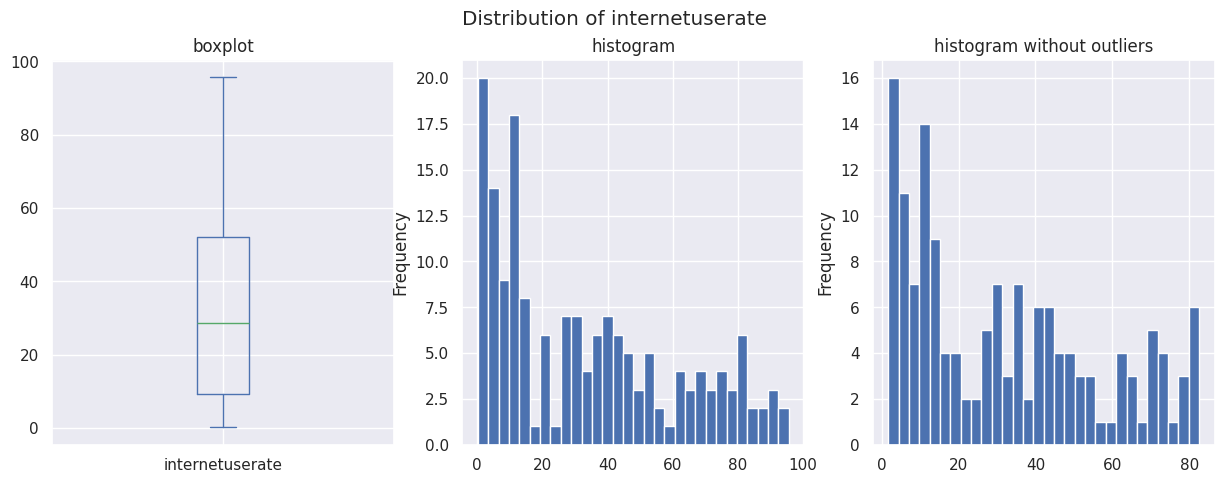

In [52]:
univariate_utils.plot_column_distribution(
  df_pib,
  "internetuserate",
  (15,5),
  30
)

### lifeexpectancy

In [53]:
df_pib["lifeexpectancy"].isnull().sum()

0

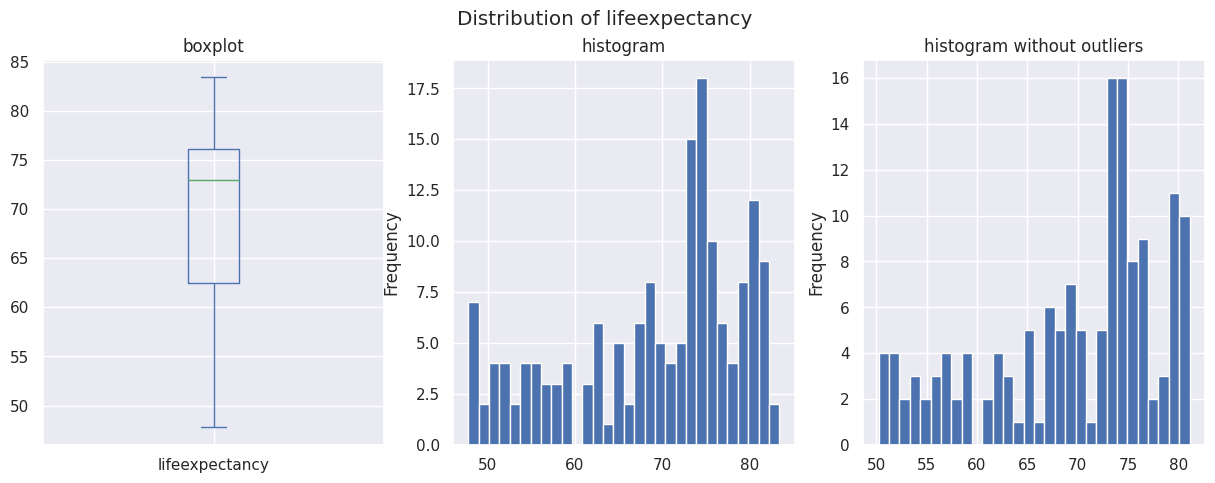

In [54]:
univariate_utils.plot_column_distribution(
  df_pib,
  "lifeexpectancy",
  (15,5),
  30
)

### oilperperson
- Column level completeness: oilperperson has 63.2% of empty values. It is too high to treat with, so the column is dropped.

In [55]:
df_pib["oilperperson"].isnull().sum()

105

In [56]:
df_pib["oilperperson"].isnull().sum()/len(df_pib["oilperperson"])

0.6325301204819277

In [57]:
df_pib.drop(columns="oilperperson", inplace=True)

### relectricperperson
- Column level completeness: relectricperperson has 21.6% of empty values. It is too high to treat with, so the column is dropped. Besides it has a correlation of 59% with internetuserate.

In [58]:
df_pib["relectricperperson"].isnull().sum()

36

In [59]:
df_pib["relectricperperson"].isnull().sum()/len(df_pib["relectricperperson"])

0.21686746987951808

In [60]:
df_pib.drop(columns="relectricperperson", inplace=True)

### polityscore
- Column level completeness: relectricperperson has 10 empty values. They are filled with average from region.

In [61]:
df_pib["polityscore"].isnull().sum()

10

In [62]:
fill_na_group(df_pib, "polityscore", "region")

In [63]:
df_pib["polityscore"].isnull().sum()

0

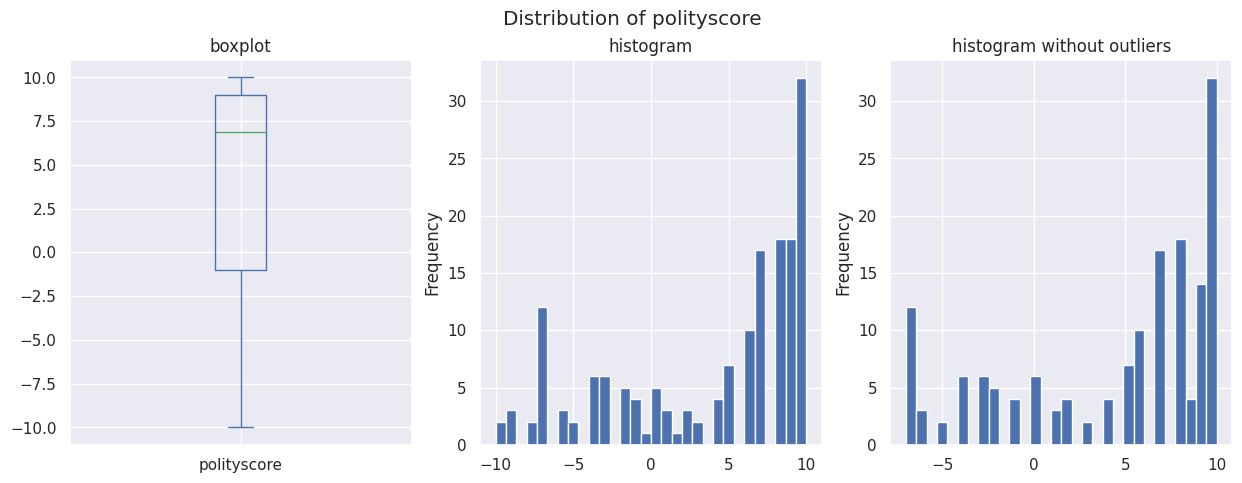

In [64]:
univariate_utils.plot_column_distribution(
  df_pib,
  "polityscore",
  (15,5),
  30
)

### suicideper100th
- Attribute level accordance: Some countries have very extreme suicide rates.

In [65]:
df_pib["suicideper100th"].isnull().sum()

0

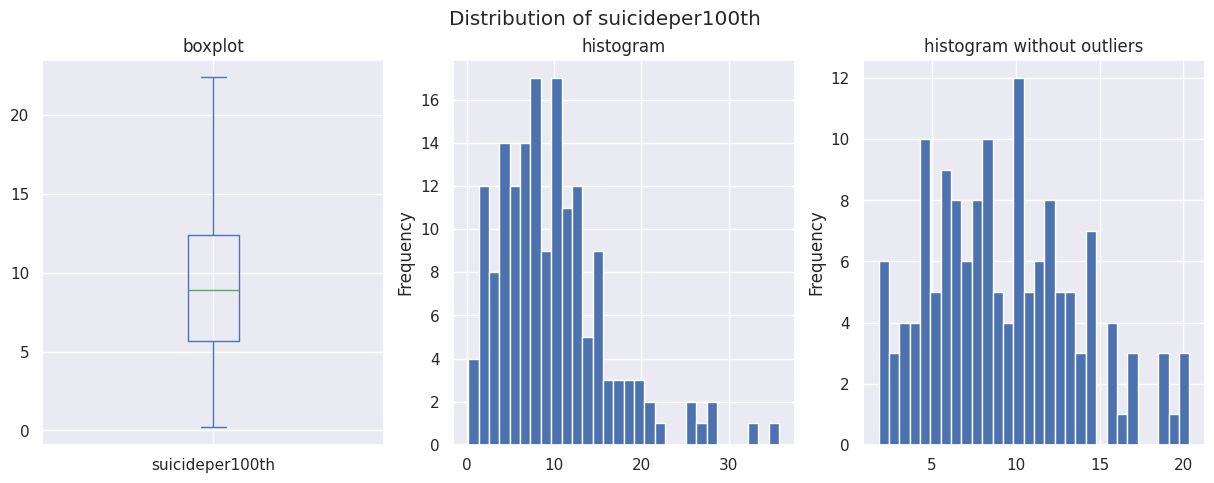

In [66]:
univariate_utils.plot_column_distribution(
  df_pib,
  "suicideper100th",
  (15,5),
  30
)

In [67]:
clip_data_by_iqr(df_pib, "suicideper100th", "top", 1.5)

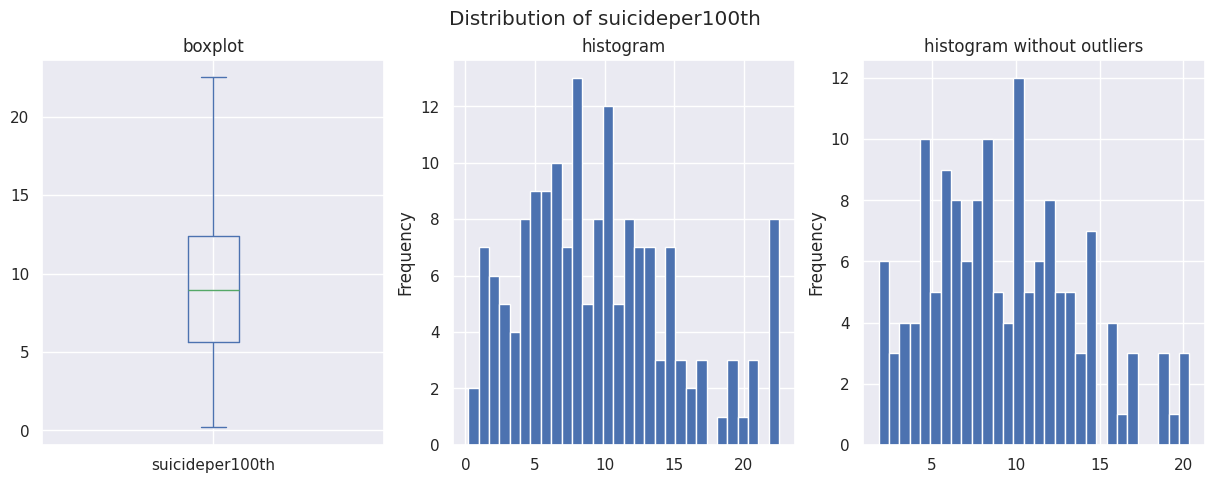

In [68]:
univariate_utils.plot_column_distribution(
  df_pib,
  "suicideper100th",
  (15,5),
  30
)

### employrate
- Column level completeness: relectricperperson has 1 empty value. It is filled with average from region.

In [69]:
df_pib["employrate"].isnull().sum()

1

In [70]:
fill_na_group(df_pib, "employrate", "region")

In [71]:
df_pib["employrate"].isnull().sum()

0

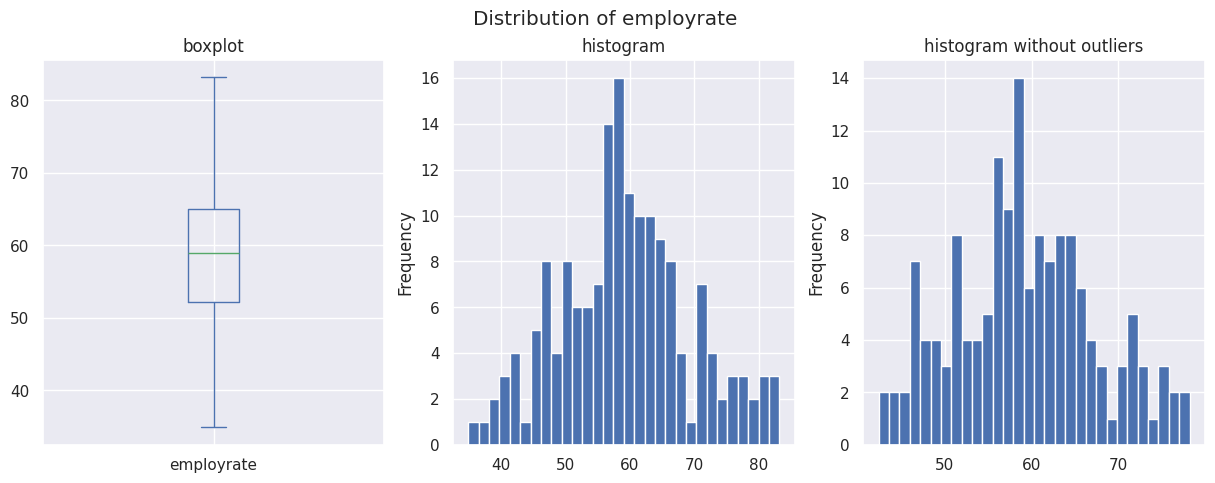

In [72]:
univariate_utils.plot_column_distribution(
  df_pib,
  "employrate",
  (15,5),
  30
)

### urbanrate

In [73]:
df_pib["urbanrate"].isnull().sum()

0

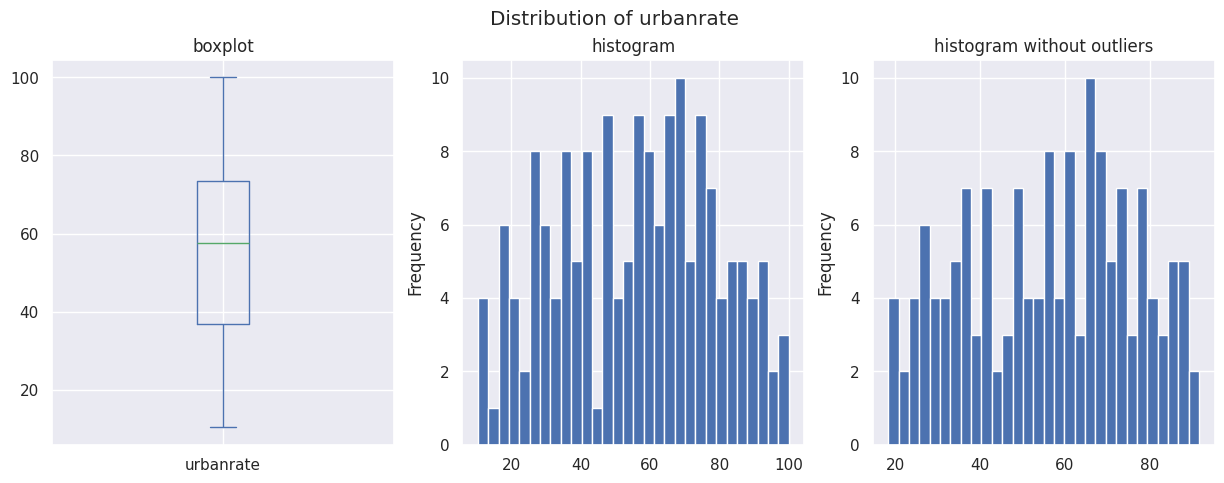

In [74]:
univariate_utils.plot_column_distribution(
  df_pib,
  "urbanrate",
  (15,5),
  30
)

### independent
- Column level accordance: Change to boolean instead of string.

In [75]:
df_pib["independent"].isnull().sum()

0

In [76]:
df_pib["independent"] = df_pib["independent"].astype(bool)

In [77]:
df_pib["independent"].value_counts()

independent
True     165
False      1
Name: count, dtype: int64

### landlocked
- Column level accordance: Change to boolean instead of string.

In [78]:
df_pib["landlocked"].isnull().sum()

0

In [79]:
df_pib["landlocked"] = df_pib["landlocked"].astype(bool)

In [80]:
df_pib["landlocked"].value_counts()

landlocked
False    130
True      36
Name: count, dtype: int64

### region

In [81]:
df_pib["region"].isnull().sum()

0

In [82]:
df_pib["region"].value_counts()

region
Africa      47
Asia        45
Europe      36
Americas    32
Oceania      6
Name: count, dtype: int64

### subregion

In [83]:
df_pib["subregion"].isnull().sum()

0

In [84]:
df_pib["subregion"].value_counts()

subregion
Western Asia                 17
Western Africa               16
Eastern Africa               15
South America                12
South-Eastern Asia           12
Northern Europe              10
Central America               9
Southern Asia                 8
Caribbean                     8
Western Europe                6
Middle Africa                 6
Northern Africa               6
Southern Europe               6
Southeast Europe              5
Central Europe                5
Central Asia                  5
Eastern Europe                4
Southern Africa               4
Eastern Asia                  3
Melanesia                     3
North America                 3
Australia and New Zealand     2
Polynesia                     1
Name: count, dtype: int64

In [85]:
df_pib.groupby(["region"])["subregion"].unique().to_dict()

{'Africa': array(['Middle Africa', 'Western Africa', 'Eastern Africa',
        'Southern Africa', 'Northern Africa'], dtype=object),
 'Americas': array(['Caribbean', 'Central America', 'South America', 'North America'],
       dtype=object),
 'Asia': array(['Western Asia', 'South-Eastern Asia', 'Eastern Asia',
        'Southern Asia', 'Central Asia'], dtype=object),
 'Europe': array(['Northern Europe', 'Southeast Europe', 'Southern Europe',
        'Western Europe', 'Central Europe', 'Eastern Europe'], dtype=object),
 'Oceania': array(['Melanesia', 'Polynesia', 'Australia and New Zealand'],
       dtype=object)}

### area
- Attribute level accordance: Some countries have very extreme large area. So the values are clipped to IQR1.5 in top values.

In [86]:
df_pib["area"].isnull().sum()

0

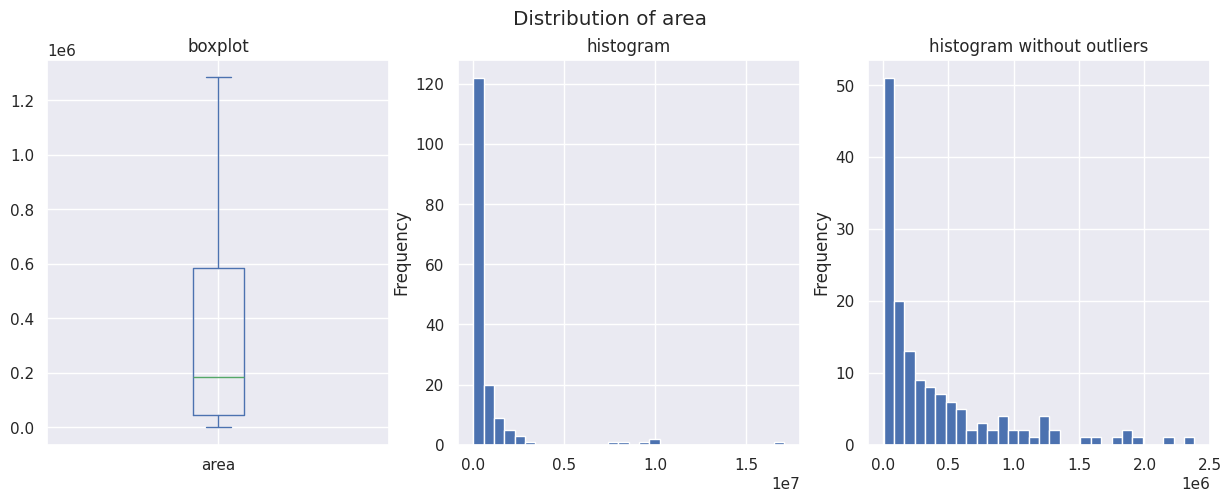

In [87]:
univariate_utils.plot_column_distribution(
  df_pib,
  "area",
  (15,5),
  30
)

In [88]:
clip_data_by_iqr(df_pib, "area", "top", 1.5)

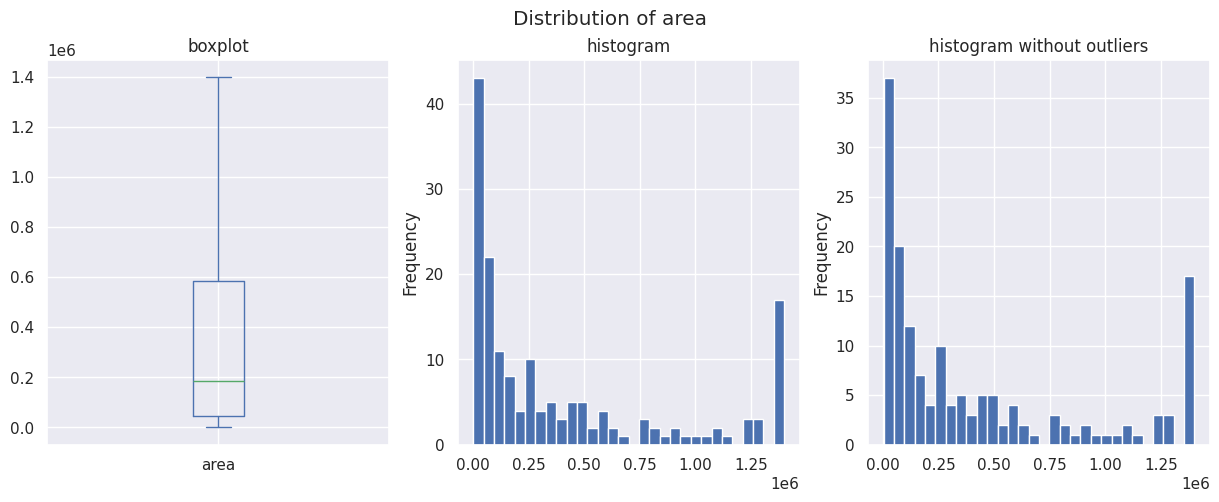

In [89]:
univariate_utils.plot_column_distribution(
  df_pib,
  "area",
  (15,5),
  30
)

### is_developed
- Column level accordance: Change to boolean instead of string.

In [90]:
df_pib["is_developed"].isnull().sum()

0

In [91]:
df_pib["is_developed"] = df_pib["is_developed"] == "True"

In [92]:
df_pib["is_developed"].value_counts()

is_developed
False    109
True      57
Name: count, dtype: int64

### Saving data

In [93]:
df_pib.to_parquet(SAVING_FILE_PATH, index=False)